 # Astro Trading Pipeline - Ternary Classification (UP/SIDEWAYS/DOWN)



 This notebook implements **3-class prediction** for cryptocurrency price movements:

 - **DOWN (0)**: Price will decrease significantly

 - **SIDEWAYS (1)**: Price will stay relatively flat (filtered by threshold)

 - **UP (2)**: Price will increase significantly



 ## Key Features:

 1. **Balanced Classes**: Auto-tuned threshold to ensure ~33% samples per class

 2. **Moon & Planet Phases**: Lunar cycle and planet elongations as features

 3. **Caching**: All intermediate data cached for fast grid search

 4. **Detailed Feature Documentation**: Every feature group explained



 ## Pipeline Steps:

 1. Setup & Config

 2. Load & Cache Market Data

 3. Create Ternary Labels (with threshold tuning)

 4. Compute & Cache Astro Data (bodies, aspects, phases)

 5. Build Features (with detailed group comments)

 6. Train 3-class Model

 7. Evaluate & Visualize

 8. Save Model & Config

 ## 0. Environment Check

In [1]:
# ═══════════════════════════════════════════════════════════════════════════════════
# CHECK DEPENDENCIES
# ═══════════════════════════════════════════════════════════════════════════════════
# Before we start, let's make sure all required packages are installed.
# These packages are essential for:
#   - xgboost: Gradient boosting model (fast, accurate for tabular data)
#   - sklearn: Machine learning utilities (train/test split, metrics, etc.)
#   - matplotlib/seaborn: Visualization (plots, charts)
#   - tqdm: Progress bars (seeing how long operations take)
#   - pyarrow: Parquet file format (fast data storage)
#   - psycopg2: PostgreSQL database connection
#   - swisseph: Swiss Ephemeris for accurate planet positions
# ═══════════════════════════════════════════════════════════════════════════════════

import importlib.util as iu

required = ["xgboost", "sklearn", "matplotlib", "seaborn", "tqdm", "pyarrow", "psycopg2", "swisseph"]
missing = [pkg for pkg in required if iu.find_spec(pkg) is None]

if missing:
    print("❌ Missing packages:", ", ".join(missing))
    print("Install with: conda install -c conda-forge " + " ".join(missing))
else:
    print("✓ All dependencies found")


✓ All dependencies found


 ## 1. Setup & Configuration

In [2]:
# ═══════════════════════════════════════════════════════════════════════════════════
# SETUP PROJECT PATHS AND IMPORTS
# ═══════════════════════════════════════════════════════════════════════════════════
# We need to find the project root directory and add it to Python's path.
# This allows us to import our custom RESEARCH modules from anywhere.
# ═══════════════════════════════════════════════════════════════════════════════════

import sys
from pathlib import Path

# Find project root by looking for RESEARCH folder
PROJECT_ROOT = Path.cwd().resolve()
if not (PROJECT_ROOT / "RESEARCH").exists():
    for parent in PROJECT_ROOT.parents:
        if (parent / "RESEARCH").exists():
            PROJECT_ROOT = parent
            break

if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))

print(f"PROJECT_ROOT: {PROJECT_ROOT}")


PROJECT_ROOT: /home/rut/ostrofun


In [3]:
# ═══════════════════════════════════════════════════════════════════════════════════
# IMPORT ALL RESEARCH MODULES
# ═══════════════════════════════════════════════════════════════════════════════════
# Our pipeline uses modular design - each module handles a specific task:
#   - config: Configuration settings (database URL, default parameters)
#   - data_loader: Load market data from PostgreSQL database
#   - labeling: Create labels (binary UP/DOWN or ternary UP/SIDEWAYS/DOWN)
#   - astro_engine: Calculate planet positions, aspects, phases
#   - features: Build feature matrix from astro data
#   - model_training: Train XGBoost model, tune threshold, evaluate
#   - visualization: Plots and charts
#   - cache_utils: Cache intermediate data (NEW in this notebook!)
# ═══════════════════════════════════════════════════════════════════════════════════

from RESEARCH.config import cfg, PROJECT_ROOT
from RESEARCH.data_loader import load_market_data, get_latest_date, get_data_paths
from RESEARCH.labeling import create_ternary_labels, get_ternary_label_stats
from RESEARCH.astro_engine import (
    init_ephemeris,
    calculate_bodies_for_dates,
    calculate_bodies_for_dates_multi,  # NEW: for helio+geo coordinates
    calculate_aspects_for_dates,
    calculate_phases_for_dates,
)
from RESEARCH.features import (
    build_full_features,
    merge_features_with_labels,
    get_feature_columns,
    get_feature_inventory,
)
from RESEARCH.model_training import (
    split_dataset,
    prepare_xy,
    train_xgb_model,
    evaluate_model,
    get_feature_importance,
    check_cuda_available,
)
from RESEARCH.visualization import (
    plot_price_distribution,
    plot_class_distribution,
    plot_price_with_labels,
    plot_confusion_matrix,
    plot_feature_importance,
    plot_predictions,
)
from RESEARCH.cache_utils import (
    cache_exists,
    save_cache,
    load_cache,
    get_cache_path,
    list_cache,
)

print("✓ All RESEARCH modules imported")


✓ All RESEARCH modules imported


In [4]:
# ═══════════════════════════════════════════════════════════════════════════════════
# CONFIGURATION FOR THIS NOTEBOOK
# ═══════════════════════════════════════════════════════════════════════════════════
# These settings control the entire pipeline. Change them here to experiment.
#
# KEY PARAMETERS:
#   DATA_START: When to start analyzing data (earlier = more training data)
#   ORB_MULTIPLIER: How strict are aspect matches (1.0 = standard, <1 = stricter)
#   LABEL_CONFIG: Horizon and Gaussian smoothing for trend detection
# ═══════════════════════════════════════════════════════════════════════════════════

import pandas as pd

# Pandas display settings (to see all columns in DataFrames)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.expand_frame_repr', False)

# ─────────────────────────────────────────────────────────────────────────────────
# DATA CONFIGURATION
# ─────────────────────────────────────────────────────────────────────────────────
DATA_START = "2017-11-01"  # Start date for analysis (Bitcoin history)

# ─────────────────────────────────────────────────────────────────────────────────
# ASTRO CONFIGURATION
# ─────────────────────────────────────────────────────────────────────────────────
# ORB_MULTIPLIER controls how "loose" aspect detection is:
#   0.5 = Very strict (only very exact aspects count)
#   1.0 = Standard orbs from classical astrology
#   1.5 = Loose (more aspects detected, but more noise)
ORB_MULTIPLIER = 1.0

# ─────────────────────────────────────────────────────────────────────────────────
# LABELING CONFIGURATION (TERNARY)
# ─────────────────────────────────────────────────────────────────────────────────
# horizon: How many days ahead we're predicting
# gauss_window: Size of Gaussian smoothing window for detrending (must be odd)
# gauss_std: Standard deviation of Gaussian (larger = smoother trend)
# balance_classes: If True, auto-tune threshold for balanced classes
LABEL_CONFIG = {
    "horizon": 1,           # Predict 1-day ahead movement
    "gauss_window": 201,    # ~10 months smoothing window
    "gauss_std": 50.0,      # Gaussian standard deviation
    "price_mode": "raw",    # Use raw prices (not log)
    "balance_classes": True,  # Auto-tune threshold for ~33% per class
}

# ─────────────────────────────────────────────────────────────────────────────────
# MODEL CONFIGURATION
# ─────────────────────────────────────────────────────────────────────────────────
MODEL_PARAMS = {
    "n_estimators": 500,      # Number of trees (more = better but slower)
    "max_depth": 4,           # Tree depth (deeper = more complex patterns)
    "learning_rate": 0.03,    # Step size (smaller = more stable)
    "subsample": 0.8,         # Fraction of samples per tree
    "colsample_bytree": 0.8,  # Fraction of features per tree
}

print(f"Active subject: {cfg.active_subject_id}")
print(f"Data start: {DATA_START}")
print(f"Orb multiplier: {ORB_MULTIPLIER}")
print(f"Label config: {LABEL_CONFIG}")


Active subject: btc
Data start: 2017-11-01
Orb multiplier: 1.0
Label config: {'horizon': 1, 'gauss_window': 201, 'gauss_std': 50.0, 'price_mode': 'raw', 'balance_classes': True}


 ## 2. Load & Cache Market Data

In [5]:
# ═══════════════════════════════════════════════════════════════════════════════════
# LOAD MARKET DATA FROM DATABASE (WITH CACHING)
# ═══════════════════════════════════════════════════════════════════════════════════
# Market data contains:
#   - date: Trading date
#   - close: Closing price (what we're trying to predict movements of)
#
# The data comes from our PostgreSQL database with historical prices.
# We cache it to avoid hitting the database repeatedly.
# ═══════════════════════════════════════════════════════════════════════════════════

# Cache key for market data
MARKET_CACHE_PARAMS = {
    "subject_id": cfg.active_subject_id,
    "start_date": DATA_START,
}

# Try to load from cache first
df_market = load_cache("market", "data", MARKET_CACHE_PARAMS, verbose=True)

if df_market is None:
    # Not in cache - load from database
    print("Loading from database...")
    df_market = load_market_data()
    
    # Filter by start date
    df_market = df_market[df_market["date"] >= DATA_START].reset_index(drop=True)
    
    # Save to cache for next time
    save_cache(df_market, "market", "data", MARKET_CACHE_PARAMS)

print(f"\nMarket data: {len(df_market)} rows")
print(f"Date range: {df_market['date'].min().date()} → {df_market['date'].max().date()}")
df_market.head()


📂 Loading from cache: market__data__btc_2017-11-01__8d63944e.parquet

Market data: 3014 rows
Date range: 2017-11-01 → 2026-01-31


,date,close
0,2017-11-01,6737.8
1,2017-11-02,7024.8
2,2017-11-03,7152.1
3,2017-11-04,7363.8
4,2017-11-05,7389.5


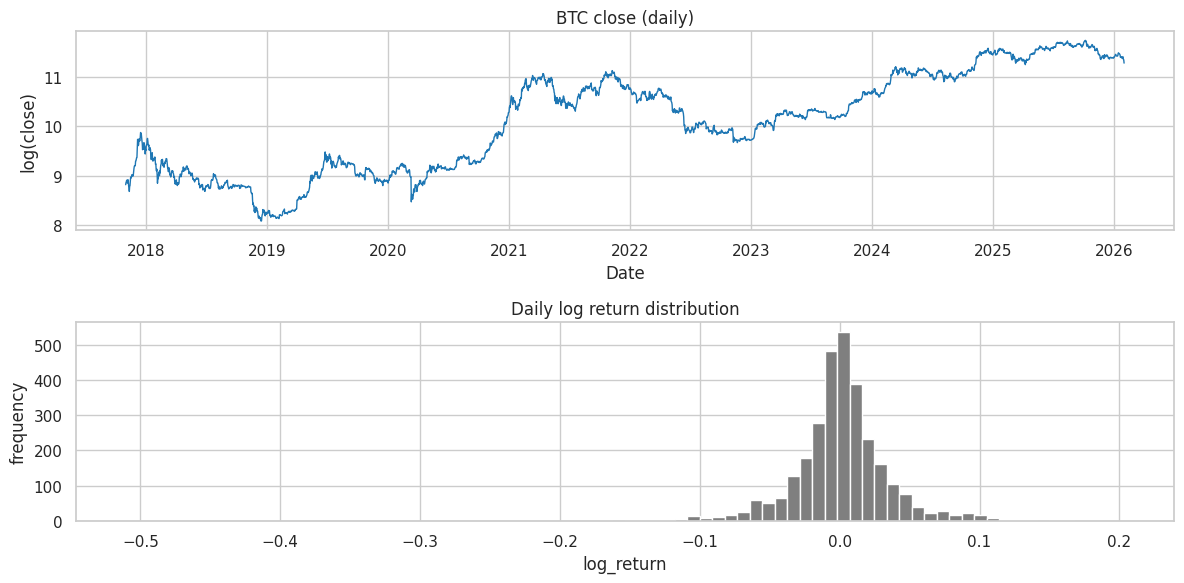

In [6]:
# ═══════════════════════════════════════════════════════════════════════════════════
# VISUALIZE PRICE DATA
# ═══════════════════════════════════════════════════════════════════════════════════
# Always good to look at the data before modeling!
# ═══════════════════════════════════════════════════════════════════════════════════

plot_price_distribution(df_market, price_mode="log")


 ## 3. Create Ternary Labels

In [7]:
# ═══════════════════════════════════════════════════════════════════════════════════
# CREATE TERNARY LABELS (UP / SIDEWAYS / DOWN)
# ═══════════════════════════════════════════════════════════════════════════════════
#
# Unlike binary classification (UP/DOWN), ternary classification adds a SIDEWAYS class
# for days when price doesn't move significantly. This is more realistic:
#
#   DOWN (0):     Price will decrease significantly (return < -threshold)
#   SIDEWAYS (1): Price will stay flat (-threshold <= return <= +threshold)
#   UP (2):       Price will increase significantly (return > +threshold)
#
# The threshold is AUTO-TUNED to balance classes (~33% each), which is important
# because imbalanced classes lead to biased models.
#
# HOW IT WORKS:
# 1. Apply Gaussian smoothing to remove long-term trend
# 2. Calculate future return (at horizon) relative to current detrended price
# 3. Binary search to find threshold where classes are balanced
# 4. Assign labels based on threshold
# ═══════════════════════════════════════════════════════════════════════════════════

# Generate unique cache key from label config
LABEL_CACHE_PARAMS = {
    "subject_id": cfg.active_subject_id,
    "start_date": DATA_START,
    "type": "ternary",
    **LABEL_CONFIG,
}

# Try cache first
cached_labels = load_cache("labels", "ternary", LABEL_CACHE_PARAMS, verbose=True)

if cached_labels is not None:
    df_labels = cached_labels
    # Need to also load the threshold
    import json
    params_path = get_cache_path("labels", "ternary_labels", LABEL_CACHE_PARAMS).with_suffix(".params.json")
    if params_path.exists():
        with open(params_path) as f:
            saved_params = json.load(f)
            threshold_used = float(saved_params.get("threshold_used", 0))
    else:
        threshold_used = 0.0
else:
    # Create new labels
    df_labels, threshold_used = create_ternary_labels(
        df_market,
        horizon=LABEL_CONFIG["horizon"],
        gauss_window=LABEL_CONFIG["gauss_window"],
        gauss_std=LABEL_CONFIG["gauss_std"],
        price_mode=LABEL_CONFIG["price_mode"],
        balance_classes=LABEL_CONFIG["balance_classes"],
    )
    
    # Save to cache (including threshold in params)
    cache_params_with_threshold = {**LABEL_CACHE_PARAMS, "threshold_used": threshold_used}
    save_cache(df_labels, "labels", "ternary", cache_params_with_threshold)

print(f"\nThreshold used for SIDEWAYS class: {threshold_used:.6f}")


═══════════════════════════════════════════════════════════════════
TERNARY LABELS CREATED: 3013 samples
───────────────────────────────────────────────────────────────────
  UP (2):         996 ( 33.1%)
  SIDEWAYS (1):  1005 ( 33.4%)
  DOWN (0):      1012 ( 33.6%)
───────────────────────────────────────────────────────────────────
  Threshold used: 167.834671
  Date range: 2017-11-01 → 2026-01-30
═══════════════════════════════════════════════════════════════════
✅ Cached: labels__ternary__btc_2017-11-01_h1_gw201__bccb092b.parquet (0.04 MB)

Threshold used for SIDEWAYS class: 167.834671


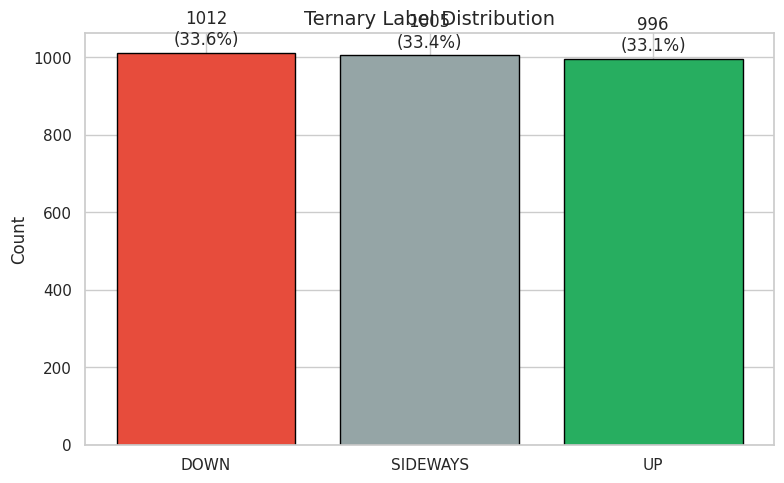

In [8]:
# ═══════════════════════════════════════════════════════════════════════════════════
# VISUALIZE CLASS DISTRIBUTION
# ═══════════════════════════════════════════════════════════════════════════════════
# We want to see that all 3 classes are roughly balanced (~33% each).
# If not balanced, the model will be biased toward the majority class.
# ═══════════════════════════════════════════════════════════════════════════════════

# Custom plot for ternary labels
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(8, 5))

class_names = ["DOWN", "SIDEWAYS", "UP"]
class_counts = [
    (df_labels["target"] == 0).sum(),
    (df_labels["target"] == 1).sum(),
    (df_labels["target"] == 2).sum(),
]
colors = ["#e74c3c", "#95a5a6", "#27ae60"]  # Red, Gray, Green

bars = ax.bar(class_names, class_counts, color=colors, edgecolor="black")

# Add count labels on bars
for bar, count in zip(bars, class_counts):
    ax.text(
        bar.get_x() + bar.get_width()/2, 
        bar.get_height() + 10, 
        f"{count}\n({100*count/len(df_labels):.1f}%)",
        ha="center", va="bottom", fontsize=12
    )

ax.set_title("Ternary Label Distribution", fontsize=14)
ax.set_ylabel("Count", fontsize=12)
plt.tight_layout()
plt.show()


 ## 4. Compute & Cache Astro Data

In [9]:
# ═══════════════════════════════════════════════════════════════════════════════════
# INITIALIZE EPHEMERIS
# ═══════════════════════════════════════════════════════════════════════════════════
# The Swiss Ephemeris is a high-precision astronomical calculation library.
# It tells us exactly where each planet is on any given date.
#
# WHAT WE CALCULATE:
#   - Bodies: Sun, Moon, Mercury, Venus, Mars, Jupiter, Saturn, Uranus, Neptune, Pluto
#   - Aspects: Angular relationships between planets (conjunction, trine, square, etc.)
# ═══════════════════════════════════════════════════════════════════════════════════

settings = init_ephemeris()
print(f"Bodies: {[b.name for b in settings.bodies]}")
print(f"Aspects: {[a.name for a in settings.aspects]}")


Bodies: ['Sun', 'Moon', 'Mercury', 'Venus', 'Mars', 'Jupiter', 'Saturn', 'Uranus', 'Neptune', 'Pluto', 'TrueNode', 'MeanNode', 'Lilith']
Aspects: ['Conjunction', 'Sextile', 'Square', 'Trine', 'Opposition']


In [10]:
# ═══════════════════════════════════════════════════════════════════════════════════
# CALCULATE PLANET POSITIONS (WITH CACHING)
# ═══════════════════════════════════════════════════════════════════════════════════
# For each date, we calculate:
#   - Longitude: Position in the zodiac (0-360°)
#   - Latitude: Distance from ecliptic plane
#   - Speed: How fast the planet is moving (negative = retrograde)
#   - Declination: Distance from celestial equator
#
# This is relatively fast (~1 second per 1000 days), but we cache anyway.
# ═══════════════════════════════════════════════════════════════════════════════════

# Cache key
date_range = f"{df_market['date'].min().date()}_{df_market['date'].max().date()}"

# ═══════════════════════════════════════════════════════════════════════════════════
# NEW: Use coord_mode='both' for GEO + HELIO coordinates!
# This gives us features like: geo_Sun_lon, helio_Mars_lon, etc.
# Heliocentric (Sun-centered) view is common in financial astrology.
# ═══════════════════════════════════════════════════════════════════════════════════
COORD_MODE = "both"  # 'geo', 'helio', or 'both'

BODIES_CACHE_PARAMS = {
    "coord_mode": COORD_MODE,
    "date_range": date_range,
}

cached_bodies = load_cache("astro", "bodies", BODIES_CACHE_PARAMS, verbose=True)

if cached_bodies is not None:
    df_bodies = cached_bodies
    # Also load geo_by_date for aspects/phases calculation
    geo_by_date = load_cache("astro", "bodies_geo_dict", BODIES_CACHE_PARAMS, verbose=False)
    helio_by_date = load_cache("astro", "bodies_helio_dict", BODIES_CACHE_PARAMS, verbose=False)
    bodies_by_date = geo_by_date  # Use geo for aspects and phases
else:
    print(f"Calculating planet positions (coord_mode={COORD_MODE})...")
    df_bodies, geo_by_date, helio_by_date = calculate_bodies_for_dates_multi(
        df_market["date"],
        settings,
        coord_mode=COORD_MODE,
        progress=True,
    )
    bodies_by_date = geo_by_date  # Use geo for aspects calculation
    
    # Cache all
    save_cache(df_bodies, "astro", "bodies", BODIES_CACHE_PARAMS)
    save_cache(geo_by_date, "astro", "bodies_geo_dict", BODIES_CACHE_PARAMS)
    if helio_by_date:
        save_cache(helio_by_date, "astro", "bodies_helio_dict", BODIES_CACHE_PARAMS)

print(f"\nBodies calculated: {len(df_bodies)} rows")
print(f"Bodies columns: {len([c for c in df_bodies.columns if c != 'date'])} features")
df_bodies.head()


Calculating planet positions (coord_mode=both)...
📍 Расчёт ГЕОЦЕНТРИЧЕСКИХ координат (Земля в центре)...


Calculating bodies: 100%|██████████| 3014/3014 [00:00<00:00, 15967.93it/s]


☀️ Расчёт ГЕЛИОЦЕНТРИЧЕСКИХ координат (Солнце в центре)...


Calculating bodies: 100%|██████████| 3014/3014 [00:00<00:00, 29443.52it/s]


✅ Объединено: 78364 записей из 2 систем координат
✅ Cached: astro__bodies__2017-11-01_2026_both__888fee83.parquet (2.51 MB)
✅ Cached: astro__bodies_geo_dict__2017-11-01_2026_both__888fee83.pkl (3.09 MB)
✅ Cached: astro__bodies_helio_dict__2017-11-01_2026_both__888fee83.pkl (3.06 MB)

Bodies calculated: 78364 rows
Bodies columns: 7 features


,date,body,lon,lat,speed,is_retro,sign,declination
0,2017-11-01,geo_Sun,218.755657,-0.000011,1.000008,False,Scorpio,-0.000011
1,2017-11-01,geo_Moon,356.209228,-2.907350,13.493332,False,Pisces,-2.907350
2,2017-11-01,geo_Mercury,232.905646,-1.409936,1.497015,False,Scorpio,-1.409936
3,2017-11-01,geo_Venus,201.888931,1.488282,1.249436,False,Libra,1.488282
4,2017-11-01,geo_Mars,185.828074,1.137132,0.631064,False,Libra,1.137132


In [11]:
# ═══════════════════════════════════════════════════════════════════════════════════
# CALCULATE ASPECTS BETWEEN PLANETS (WITH CACHING)
# ═══════════════════════════════════════════════════════════════════════════════════
# Aspects are angular relationships between planets:
#   - Conjunction (0°): Planets at same position (merging energies)
#   - Sextile (60°): Harmonious, opportunity
#   - Square (90°): Tension, challenge
#   - Trine (120°): Easy flow, harmony
#   - Opposition (180°): Polarization, awareness
#
# Each aspect has an ORB - allowed deviation from exact angle.
# ORB_MULTIPLIER scales these orbs (lower = stricter matching).
# ═══════════════════════════════════════════════════════════════════════════════════

ASPECTS_CACHE_PARAMS = {
    "orb_mult": ORB_MULTIPLIER,
    "coord_mode": "geo",
    "date_range": date_range,
}

cached_aspects = load_cache("astro", "aspects", ASPECTS_CACHE_PARAMS, verbose=True)

if cached_aspects is not None:
    df_aspects = cached_aspects
else:
    print("Calculating aspects...")
    df_aspects = calculate_aspects_for_dates(
        bodies_by_date,
        settings,
        orb_mult=ORB_MULTIPLIER,
        progress=True,
    )
    
    save_cache(df_aspects, "astro", "aspects", ASPECTS_CACHE_PARAMS)

print(f"\nAspects: {len(df_aspects)} rows")
df_aspects.head()


📂 Loading from cache: astro__aspects__2017-11-01_2026_geo_orb1.0__bcbb5a97.parquet

Aspects: 48953 rows


,date,p1,p2,aspect,orb,is_exact,is_applying
0,2017-11-01,Sun,Jupiter,Conjunction,4.092977,False,False
1,2017-11-01,Sun,Neptune,Trine,2.840517,False,True
2,2017-11-01,Moon,Mercury,Trine,3.303582,False,False
3,2017-11-01,Moon,Saturn,Square,1.599373,False,False
4,2017-11-01,Moon,Lilith,Square,2.880143,False,False


In [12]:
# ═══════════════════════════════════════════════════════════════════════════════════
# CALCULATE MOON PHASES AND PLANET ELONGATIONS (WITH CACHING)
# ═══════════════════════════════════════════════════════════════════════════════════
# MOON PHASES:
#   - phase_angle: Angular distance between Moon and Sun (0-360°)
#   - phase_ratio: Normalized (0=New Moon, 0.5=Full Moon, 1=New again)
#   - illumination: Fraction of Moon illuminated (0-1)
#   - lunar_day: Day in lunar cycle (1-29.5)
#
# PLANET ELONGATIONS:
#   - How far each planet appears from the Sun (as seen from Earth)
#   - Positive = evening star (planet visible after sunset)
#   - Negative = morning star (planet visible before sunrise)
#   - Mercury max: ~28°, Venus max: ~47°, outer planets: up to 180° (opposition)
#
# WHY THIS MATTERS:
#   - Lunar cycles are one of the most studied cycles in financial astrology
#   - New/Full moons are often associated with market turning points
#   - Planet elongations affect visibility and "intensity" in traditional astrology
# ═══════════════════════════════════════════════════════════════════════════════════

PHASES_CACHE_PARAMS = {
    "date_range": date_range,
}

cached_phases = load_cache("astro", "phases", PHASES_CACHE_PARAMS, verbose=True)

if cached_phases is not None:
    df_phases = cached_phases
else:
    print("Calculating moon phases and planet elongations...")
    df_phases = calculate_phases_for_dates(
        bodies_by_date,
        progress=True,
    )
    
    save_cache(df_phases, "astro", "phases", PHASES_CACHE_PARAMS)

print(f"\nPhases: {len(df_phases)} rows")
print(f"Phase columns: {list(df_phases.columns)}")
df_phases.head()


📂 Loading from cache: astro__phases__2017-11-01_2026__ce9ad343.parquet

Phases: 3014 rows
Phase columns: ['date', 'moon_phase_angle', 'moon_phase_ratio', 'moon_illumination', 'lunar_day', 'Mercury_elongation', 'Mercury_elongation_abs', 'Venus_elongation', 'Venus_elongation_abs', 'Mars_elongation', 'Mars_elongation_abs', 'Jupiter_elongation', 'Jupiter_elongation_abs', 'Saturn_elongation', 'Saturn_elongation_abs', 'Uranus_elongation', 'Uranus_elongation_abs', 'Neptune_elongation', 'Neptune_elongation_abs', 'Pluto_elongation', 'Pluto_elongation_abs', 'TrueNode_elongation', 'TrueNode_elongation_abs', 'MeanNode_elongation', 'MeanNode_elongation_abs', 'Lilith_elongation', 'Lilith_elongation_abs']


,date,moon_phase_angle,moon_phase_ratio,moon_illumination,lunar_day,Mercury_elongation,Mercury_elongation_abs,Venus_elongation,Venus_elongation_abs,Mars_elongation,Mars_elongation_abs,Jupiter_elongation,Jupiter_elongation_abs,Saturn_elongation,Saturn_elongation_abs,Uranus_elongation,Uranus_elongation_abs,Neptune_elongation,Neptune_elongation_abs,Pluto_elongation,Pluto_elongation_abs,TrueNode_elongation,TrueNode_elongation_abs,MeanNode_elongation,MeanNode_elongation_abs,Lilith_elongation,Lilith_elongation_abs
0,2017-11-01,137.453571,0.381815,0.868365,12.275236,14.149989,14.149989,-16.866726,16.866726,-32.927583,32.927583,-4.092977,4.092977,45.854198,45.854198,167.271639,167.271639,122.840517,122.840517,68.372035,68.372035,-77.755116,77.755116,-78.628966,78.628966,50.333714,50.333714
1,2017-11-02,150.180767,0.417169,0.933799,13.319241,14.642583,14.642583,-16.617337,16.617337,-33.296790,33.296790,-4.875197,4.875197,44.947945,44.947945,166.231966,166.231966,121.828704,121.828704,67.388293,67.388293,-78.869747,78.869747,-79.682192,79.682192,49.444983,49.444983
2,2017-11-03,163.357538,0.453771,0.979055,14.400124,15.126290,15.126290,-16.368030,16.368030,-33.666523,33.666523,-5.658005,5.658005,44.042135,44.042135,165.192052,165.192052,120.816923,120.816923,66.404528,66.404528,-80.027069,80.027069,-80.735892,80.735892,48.555775,48.555775
3,2017-11-04,176.917621,0.491438,0.999277,15.512449,15.600964,15.600964,-16.118820,16.118820,-34.036789,34.036789,-6.441434,6.441434,43.136739,43.136739,164.151902,164.151902,119.805165,119.805165,65.420725,65.420725,-81.214592,81.214592,-81.790079,81.790079,47.666076,47.666076
4,2017-11-05,190.746132,0.529850,0.991231,16.646794,16.066390,16.066390,-15.869722,15.869722,-34.407593,34.407593,-7.225516,7.225516,42.231725,42.231725,163.111513,163.111513,118.793420,118.793420,64.436862,64.436862,-82.412711,82.412711,-82.844770,82.844770,46.775869,46.775869


 ## 5. Build Features

In [13]:
# ═══════════════════════════════════════════════════════════════════════════════════
# FEATURE GROUPS EXPLAINED FOR BEGINNERS
# ═══════════════════════════════════════════════════════════════════════════════════
#
# Our feature matrix contains several groups of astrological indicators:
#
# ═══════════════════════════════════════════════════════════════════════════════════
# GROUP 1: PLANET COORDINATES
# ═══════════════════════════════════════════════════════════════════════════════════
# For each celestial body (Sun, Moon, Mercury, Venus, Mars, Jupiter, Saturn, etc.):
#
#   {Body}_lon       - Ecliptic longitude (0-360°)
#                      This is the planet's position in the zodiac circle.
#                      Think of it as "where" the planet is.
#                      0° = start of Aries, 30° = start of Taurus, etc.
#
#   {Body}_lat       - Ecliptic latitude
#                      How far north/south the planet is from the ecliptic plane.
#                      Usually small for most planets, larger for Pluto.
#
#   {Body}_speed     - Daily motion in degrees
#                      How fast the planet is moving.
#                      NEGATIVE = RETROGRADE (appears to move backward)
#                      Retrograde periods are considered significant.
#
#   {Body}_is_retro  - Boolean flag (0 or 1)
#                      1 if planet is in retrograde motion.
#                      Mercury retrograde is most famous in pop astrology!
#
#   {Body}_decl      - Declination  
#                      Distance from celestial equator (like latitude on sky).
#                      High declination = planet far from equator.
#
#   {Body}_sign_idx  - Zodiac sign index (0-11)
#                      0=Aries, 1=Taurus, 2=Gemini, ..., 11=Pisces
#                      Different signs have different "qualities."
#
# ═══════════════════════════════════════════════════════════════════════════════════
# GROUP 2: ASPECTS BETWEEN PLANETS
# ═══════════════════════════════════════════════════════════════════════════════════
# Aspects are angular relationships between pairs of planets:
#
#   aspect_{P1}_{P2}_{Type}  - Binary flag (0 or 1)
#                              1 if the aspect is active today.
#
# ASPECT TYPES (angles between planets):
#   conjunction (0°)   - Planets at same position → fusion of energies
#   sextile (60°)      - Harmonious, opportunities
#   square (90°)       - Tension, challenges, action needed
#   trine (120°)       - Easy flow, natural harmony
#   opposition (180°)  - Polarization, awareness, contrast
#
# ORBS: Each aspect has an allowed deviation (orb).
#   - Major aspects (conjunction, trine, square, opposition): 8° orb
#   - Minor aspects (sextile): 6° orb
#   - ORB_MULTIPLIER scales these (0.5 = 4°/3°, 1.5 = 12°/9°)
#
# ═══════════════════════════════════════════════════════════════════════════════════
# GROUP 3: MOON PHASES (KEY GROUP!)
# ═══════════════════════════════════════════════════════════════════════════════════
# The lunar cycle is ~29.5 days and widely studied in financial astrology:
#
#   moon_phase_angle    - Angular distance Moon-Sun (0-360°)
#                         0° = New Moon, 180° = Full Moon
#
#   moon_phase_ratio    - Normalized to 0-1 range
#                         0 = New Moon, 0.5 = Full Moon, 1 = New Moon again
#                         Easy to use as a cyclic feature!
#
#   moon_illumination   - Fraction of Moon illuminated (0-1)
#                         0 = invisible (new), 1 = fully lit (full)
#
#   lunar_day           - Day in lunar cycle (1-29.5)
#                         Traditional lunar calendars count these days.
#
# FINANCIAL ASTROLOGY CLAIMS:
#   - New Moon: Often marks market lows, good for buying
#   - Full Moon: Often marks market highs, increased volatility
#   - Waxing Moon (growing): Bullish tendency
#   - Waning Moon (shrinking): Bearish tendency
#
# ═══════════════════════════════════════════════════════════════════════════════════
# GROUP 4: PLANET ELONGATIONS
# ═══════════════════════════════════════════════════════════════════════════════════
# Elongation = angular distance from Sun as seen from Earth:
#
#   {Planet}_elongation      - Value from -180° to +180°
#                              Positive → Evening star (east of Sun)
#                              Negative → Morning star (west of Sun)
#
#   {Planet}_elongation_abs  - Absolute value (0-180°)
#                              How "far" the planet appears from Sun.
#
# WHY IT MATTERS:
#   - Mercury/Venus: Can only be seen near Sun (max ~28°/47°)
#   - Maximum elongation = best visibility, considered "strongest"
#   - Outer planets: 180° = opposition (opposite Sun, brightest, closest to Earth)
#
# ═══════════════════════════════════════════════════════════════════════════════════


In [14]:
# ═══════════════════════════════════════════════════════════════════════════════════
# BUILD FEATURE MATRIX (WITH CACHING)
# ═══════════════════════════════════════════════════════════════════════════════════
# Combine all astro data into a single feature matrix.
# Each row = one date, each column = one feature.
# ═══════════════════════════════════════════════════════════════════════════════════

FEATURES_CACHE_PARAMS = {
    "orb_mult": ORB_MULTIPLIER,
    "coord_mode": "geo",
    "date_range": date_range,
    "include_phases": True,
    "include_pair_aspects": True,
}

cached_features = load_cache("features", "ternary", FEATURES_CACHE_PARAMS, verbose=True)

if cached_features is not None:
    df_features = cached_features
else:
    print("Building feature matrix...")
    df_features = build_full_features(
        df_bodies,
        df_aspects,
        df_transits=None,  # No transit aspects in this version
        df_phases=df_phases,  # Include moon phases and elongations!
        include_pair_aspects=True,
        include_transit_aspects=False,
        exclude_bodies=None,  # Include all bodies
    )
    
    save_cache(df_features, "features", "ternary", FEATURES_CACHE_PARAMS)

print(f"\nFeatures shape: {df_features.shape}")
print(f"Feature columns: {len([c for c in df_features.columns if c != 'date'])}")


📂 Loading from cache: features__ternary__2017-11-01_2026_geo_orb1.0_phases__328ed5d1.parquet

Features shape: (3014, 774)
Feature columns: 773


In [15]:
# ═══════════════════════════════════════════════════════════════════════════════════
# MERGE FEATURES WITH LABELS
# ═══════════════════════════════════════════════════════════════════════════════════
# Join features and labels on date.
# Using LEFT JOIN + forward-fill so we have labels for all days.
# ═══════════════════════════════════════════════════════════════════════════════════

df_dataset = merge_features_with_labels(df_features, df_labels)
print(f"\nDataset shape: {df_dataset.shape}")


Merged dataset: 3014 samples (ALL days, forward-filled)
Features: 773

Dataset shape: (3014, 775)


In [16]:
# ═══════════════════════════════════════════════════════════════════════════════════
# FEATURE INVENTORY
# ═══════════════════════════════════════════════════════════════════════════════════
# Let's see what features we have, grouped by type.
# ═══════════════════════════════════════════════════════════════════════════════════

feature_inventory = get_feature_inventory(df_dataset)
print("\nFeature groups:")
print(feature_inventory.groupby("group").size())

# Show first few features in each group
for group in feature_inventory["group"].unique()[:5]:
    print(f"\n{group.upper()}:")
    print(feature_inventory[feature_inventory["group"] == group].head(3))



Feature groups:
group
Jupiter       7
Lilith        7
Mars          7
MeanNode      7
Mercury       7
Moon          5
Neptune       7
Pluto         7
Saturn        7
Sun           5
TrueNode      7
Uranus        7
Venus         7
aspect      682
lunar         1
moon          3
dtype: int64

JUPITER:
                  feature    group       mean        std         min         max  missing_%
0     Jupiter_declination  Jupiter  -0.355063   0.797135   -1.621115    1.276286        0.0
1      Jupiter_elongation  Jupiter  -4.778282  98.420522 -179.978355  179.854404        0.0
2  Jupiter_elongation_abs  Jupiter  83.847653  51.736605    0.053804  179.978355        0.0

LILITH:
                 feature   group       mean         std         min         max  missing_%
7     Lilith_declination  Lilith  -0.311817    3.497465   -5.145396    5.145396        0.0
8      Lilith_elongation  Lilith  -0.289521  101.791972 -179.859687  179.985974        0.0
9  Lilith_elongation_abs  Lilith  87.256064   52

 ## 6. Train 3-Class Model

In [17]:
# ═══════════════════════════════════════════════════════════════════════════════════
# CHECK CUDA AVAILABILITY
# ═══════════════════════════════════════════════════════════════════════════════════
# XGBoost can use GPU (CUDA) for much faster training.
# If you have an NVIDIA GPU, this will speed things up significantly.
# ═══════════════════════════════════════════════════════════════════════════════════

use_cuda, device = check_cuda_available()
print(f"Using device: {device}")


Using device: cuda


In [18]:
# ═══════════════════════════════════════════════════════════════════════════════════
# SPLIT DATA: TRAIN / VALIDATION / TEST
# ═══════════════════════════════════════════════════════════════════════════════════
# Time-based split (important for financial data!):
#   - Train: First 70% of data (learn patterns)
#   - Validation: Next 15% (tune hyperparameters)
#   - Test: Last 15% (final evaluation, never touch during training!)
#
# WHY TIME-BASED?
#   Unlike random split, time-based prevents "future leakage" -
#   we never train on data that comes AFTER our test period.
# ═══════════════════════════════════════════════════════════════════════════════════

train_df, val_df, test_df = split_dataset(df_dataset, train_ratio=0.7, val_ratio=0.15)

print(f"Train: {train_df['date'].min().date()} → {train_df['date'].max().date()} ({len(train_df)} samples)")
print(f"Val:   {val_df['date'].min().date()} → {val_df['date'].max().date()} ({len(val_df)} samples)")
print(f"Test:  {test_df['date'].min().date()} → {test_df['date'].max().date()} ({len(test_df)} samples)")

# Check class distribution in each split
for name, df in [("Train", train_df), ("Val", val_df), ("Test", test_df)]:
    counts = df["target"].value_counts().sort_index()
    print(f"\n{name} class distribution:")
    for label, count in counts.items():
        class_name = ["DOWN", "SIDEWAYS", "UP"][label]
        print(f"  {class_name}: {count} ({100*count/len(df):.1f}%)")


Split: Train=2109, Val=452, Test=453
Train: 2017-11-01 → 2023-08-10 (2109 samples)
Val:   2023-08-11 → 2024-11-04 (452 samples)
Test:  2024-11-05 → 2026-01-31 (453 samples)

Train class distribution:
  DOWN: 617 (29.3%)
  SIDEWAYS: 870 (41.3%)
  UP: 622 (29.5%)

Val class distribution:
  DOWN: 194 (42.9%)
  SIDEWAYS: 87 (19.2%)
  UP: 171 (37.8%)

Test class distribution:
  DOWN: 202 (44.6%)
  SIDEWAYS: 48 (10.6%)
  UP: 203 (44.8%)


In [19]:
# ═══════════════════════════════════════════════════════════════════════════════════
# PREPARE DATA FOR MODEL
# ═══════════════════════════════════════════════════════════════════════════════════
# Separate features (X) from target (y) for each split.
# ═══════════════════════════════════════════════════════════════════════════════════

feature_cols = get_feature_columns(df_dataset)
X_train, y_train = prepare_xy(train_df, feature_cols)
X_val, y_val = prepare_xy(val_df, feature_cols)
X_test, y_test = prepare_xy(test_df, feature_cols)

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val:   {X_val.shape}, y_val:   {y_val.shape}")
print(f"X_test:  {X_test.shape}, y_test:  {y_test.shape}")


X_train: (2109, 773), y_train: (2109,)
X_val:   (452, 773), y_val:   (452,)
X_test:  (453, 773), y_test:  (453,)


In [20]:
# ═══════════════════════════════════════════════════════════════════════════════════
# TRAIN XGBOOST MODEL (3 CLASSES)
# ═══════════════════════════════════════════════════════════════════════════════════
# XGBoost (eXtreme Gradient Boosting) is one of the best algorithms for tabular data.
# It works by building many small decision trees that correct each other's errors.
#
# For 3 classes, XGBoost uses "softmax" to output probability for each class.
# ═══════════════════════════════════════════════════════════════════════════════════

print("Training XGBoost model (3 classes)...")

# ═══════════════════════════════════════════════════════════════════════════════════
# KEY: weight_power=2.0 for stronger minority class weighting!
# This prevents the model from predicting only SIDEWAYS class.
# Standard balanced weights (power=1.0) often aren't enough for 3+ classes.
# ═══════════════════════════════════════════════════════════════════════════════════
WEIGHT_POWER = 2.0  # 1.0=standard, 2.0=stronger (recommended for ternary)

model = train_xgb_model(
    X_train, y_train,
    X_val, y_val,
    feature_cols,
    n_classes=3,  # TERNARY: 3 classes instead of 2!
    device=device,
    weight_power=WEIGHT_POWER,  # NEW: stronger sample weights
    **MODEL_PARAMS,
)

print("✓ Model trained")


Training XGBoost model (3 classes)...
✓ Model trained


 ## 7. Evaluate & Visualize

In [21]:
# ═══════════════════════════════════════════════════════════════════════════════════
# PREDICT ON TEST SET
# ═══════════════════════════════════════════════════════════════════════════════════
# For 3 classes, we pick the class with highest probability.
# Note: model is a wrapper, we need model.model for predict_proba
#       and model.scaler to scale the data first.
# ═══════════════════════════════════════════════════════════════════════════════════

# Scale features using the same scaler used in training
X_test_scaled = model.scaler.transform(X_test)

# Get class probabilities from the inner XGBoost model
y_proba = model.model.predict_proba(X_test_scaled)

# Pick class with highest probability
y_pred = y_proba.argmax(axis=1)

print(f"Predictions shape: {y_pred.shape}")
print(f"Unique predictions: {set(y_pred)}")


Predictions shape: (453,)
Unique predictions: {np.int64(0), np.int64(1), np.int64(2)}


/mnt/w/WSL/btc/lib/python3.12/site-packages/xgboost/core.py:774: UserWarning: [22:39:34] WARNING: /workspace/src/common/error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)


In [22]:
# ═══════════════════════════════════════════════════════════════════════════════════
# EVALUATE MODEL
# ═══════════════════════════════════════════════════════════════════════════════════

results = evaluate_model(y_test, y_pred, label_names=["DOWN", "SIDEWAYS", "UP"])



=== Model Evaluation ===
Accuracy: 0.2826
Balanced Accuracy: 0.3536
MCC: 0.0130
F1 Macro: 0.2752
Summary Score: 0.3144

Majority Baseline: acc=0.4481, bal_acc=0.3333
Prev-Label Baseline: acc=0.3951, bal_acc=0.3370

Classification Report:
              precision    recall  f1-score   support

        DOWN       0.43      0.18      0.25       202
    SIDEWAYS       0.12      0.56      0.19        48
          UP       0.46      0.32      0.38       203

    accuracy                           0.28       453
   macro avg       0.34      0.35      0.28       453
weighted avg       0.41      0.28      0.30       453

95% Bootstrap CI:
  acc: [0.2472, 0.3224]
  bal_acc: [0.3052, 0.4068]
  f1_macro: [0.2397, 0.3136]


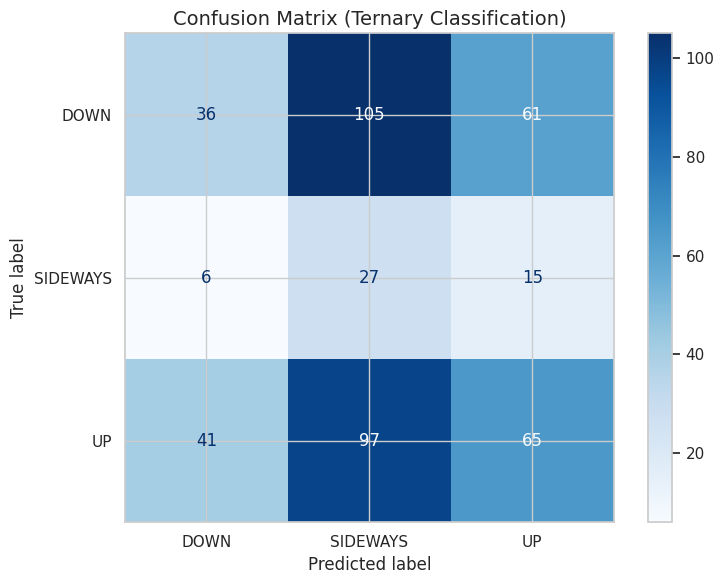

In [23]:
# ═══════════════════════════════════════════════════════════════════════════════════
# CONFUSION MATRIX (3x3)
# ═══════════════════════════════════════════════════════════════════════════════════
# Shows how predictions compare to actual labels.
# Diagonal = correct predictions, off-diagonal = errors.
# ═══════════════════════════════════════════════════════════════════════════════════

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=["DOWN", "SIDEWAYS", "UP"])
disp.plot(ax=ax, cmap="Blues", values_format="d")
ax.set_title("Confusion Matrix (Ternary Classification)", fontsize=14)
plt.tight_layout()
plt.show()


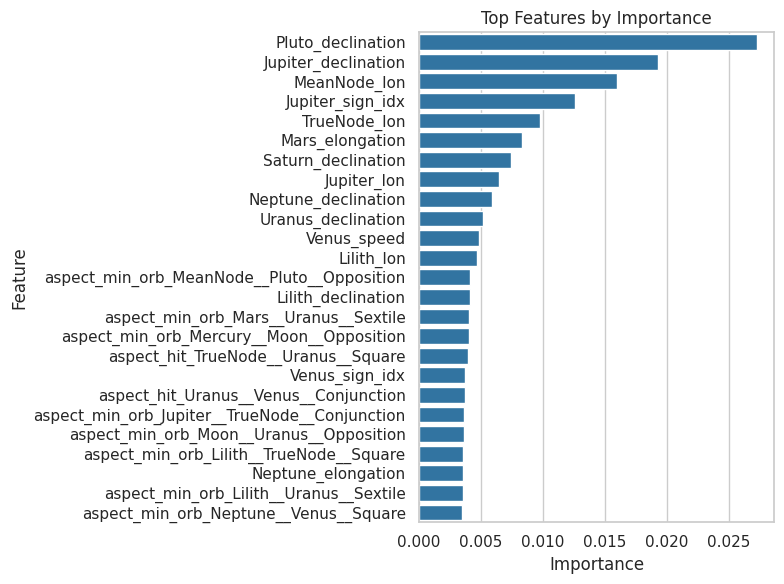

In [24]:
# ═══════════════════════════════════════════════════════════════════════════════════
# FEATURE IMPORTANCE
# ═══════════════════════════════════════════════════════════════════════════════════
# Which features matter most for predictions?
# Higher importance = more influence on model decisions.
# ═══════════════════════════════════════════════════════════════════════════════════

imp_df = get_feature_importance(model, feature_cols, top_n=25)
plot_feature_importance(imp_df)


In [25]:
# ═══════════════════════════════════════════════════════════════════════════════════
# SHOW TOP FEATURES BY GROUP
# ═══════════════════════════════════════════════════════════════════════════════════

# Group features
imp_df["group"] = imp_df["feature"].apply(lambda x: x.split("_")[0] if "_" in x else "other")

print("\nTop 5 features by group:")
for group in ["moon", "aspect", "Sun", "Mercury", "Venus"]:
    subset = imp_df[imp_df["feature"].str.contains(group, case=False)].head(3)
    if not subset.empty:
        print(f"\n{group.upper()}:")
        for _, row in subset.iterrows():
            print(f"  {row['feature']}: {row['importance']:.4f}")



Top 5 features by group:

MOON:
  aspect_min_orb_Mercury__Moon__Opposition: 0.0040
  aspect_min_orb_Moon__Uranus__Opposition: 0.0036

ASPECT:
  aspect_min_orb_MeanNode__Pluto__Opposition: 0.0041
  aspect_min_orb_Mars__Uranus__Sextile: 0.0040
  aspect_min_orb_Mercury__Moon__Opposition: 0.0040

MERCURY:
  aspect_min_orb_Mercury__Moon__Opposition: 0.0040

VENUS:
  Venus_speed: 0.0048
  Venus_sign_idx: 0.0037
  aspect_hit_Uranus__Venus__Conjunction: 0.0037


 ## 8. Save Model & Config

In [26]:
# ═══════════════════════════════════════════════════════════════════════════════════
# SAVE MODEL ARTIFACT
# ═══════════════════════════════════════════════════════════════════════════════════
# Save everything needed to use the model later:
#   - model: The trained XGBoost model
#   - scaler: Feature scaler (if any)
#   - feature_names: List of features (in order)
#   - config: All configuration used (for reproducibility)
# ═══════════════════════════════════════════════════════════════════════════════════

from joblib import dump
import json

artifact_dir = PROJECT_ROOT / "models_artifacts"
artifact_dir.mkdir(parents=True, exist_ok=True)

# Full artifact with model and config
artifact = {
    "model": model.model,
    "scaler": model.scaler,
    "feature_names": feature_cols,
    "n_classes": 3,
    "class_names": ["DOWN", "SIDEWAYS", "UP"],
    "threshold_used": threshold_used,
    "config": {
        "label_config": LABEL_CONFIG,
        "orb_multiplier": ORB_MULTIPLIER,
        "model_params": MODEL_PARAMS,
        "data_start": DATA_START,
    },
}

out_path = artifact_dir / "xgb_astro_ternary.joblib"
dump(artifact, out_path)
print(f"✓ Model saved: {out_path}")

# Also save config as JSON for easy reading
config_path = artifact_dir / "xgb_astro_ternary_config.json"
with open(config_path, "w") as f:
    json.dump(artifact["config"], f, indent=2, default=str)
print(f"✓ Config saved: {config_path}")


✓ Model saved: /home/rut/ostrofun/models_artifacts/xgb_astro_ternary.joblib
✓ Config saved: /home/rut/ostrofun/models_artifacts/xgb_astro_ternary_config.json


In [27]:
# ═══════════════════════════════════════════════════════════════════════════════════
# SHOW CACHED FILES
# ═══════════════════════════════════════════════════════════════════════════════════
# Let's see what we've cached for later use (grid search, etc.)
# ═══════════════════════════════════════════════════════════════════════════════════

print("\n📁 Cached files:")
cache_df = list_cache()
if not cache_df.empty:
    for _, row in cache_df.iterrows():
        print(f"  {row['category']}/{row['name']}: {row['size_mb']:.2f} MB")
else:
    print("  No cached files found")



📁 Cached files:
  astro/aspects: 0.55 MB
  astro/bodies: 2.51 MB
  astro/bodies: 1.43 MB
  astro/bodies_dict: 3.09 MB
  astro/bodies_geo_dict: 3.09 MB
  astro/bodies_helio_dict: 3.06 MB
  astro/phases: 0.74 MB
  features/ternary: 2.81 MB
  labels/ternary: 0.04 MB
  market/data: 0.04 MB


 ---

 ## Summary



 This notebook implements a **3-class prediction model** for cryptocurrency price movements:



 ### Key Differences from Binary Model:

 - **3 classes**: DOWN (0), SIDEWAYS (1), UP (2) instead of just UP/DOWN

 - **Auto-balanced**: Threshold tuned to ensure ~33% per class

 - **Moon phases**: Lunar cycle features (phase, illumination, lunar day)

 - **Planet elongations**: Angular distance from Sun

 - **Full caching**: All intermediate data cached for grid search



 ### Next Steps:

 1. **Grid Search**: Use cached data to find optimal parameters

 2. **Body Ablation**: Test which planets matter most

 3. **Feature Engineering**: Add more cycles (houses, progressions, etc.)



 ### Files Created:

 - `models_artifacts/xgb_astro_ternary.joblib` - Trained model

 - `models_artifacts/xgb_astro_ternary_config.json` - Configuration

 - `RESEARCH/cache/*` - Cached intermediate data